# 1. Business Problem
## 1.1 Problem Context
Our client is an online retailer based in the UK. They sell all-occasion gifts, and many of their customers are wholesalers.
* Most of their customers are from the UK, but they have a small percent of customers from other countries.
* They want to create groups of these international customers based on their previous purchase patterns.
* Their goal is to provide more tailored services and improve the way they market to these international customers.

## 1.2 Problems with current approach
Currently, the retailer simply groups their international customers by country. As you'll see in the project, this is quite inefficient because:
* There's a large number of countries (which kind of defeats the purpose of creating groups).
* Some countries have very few customers.
* This approach treats large and small customers the same, regardless of their purchase patterns.

## 1.3 Problem Statement
The retailer has hired us to help them create customer clusters, a.k.a **"customer segments"** through a data-driven approach.
* They've provided us a dataset of past purchase data at the transaction level.
* Our task is to build a clustering model using that dataset.
* Our clustering model should factor in both aggregate sales patterns and specific items purchased.

## 1.4 Business Objectives and constraints

# 2. Machine Learning Problem
## 2.1 Data Overview
For this project:
* The dataset has 35116 observations for previous international transactions.
* The observations span 37 different countries.
* **Note:** There is no target variable.

We have the following features:

Invoice information
* 'InvoiceNo' – Unique ID for invoice
* 'InvoiceDate' – Invoice date

Item information
* 'StockCode' – Unique ID for item
* 'Description' – Text description for item
* 'Quantity' – Units per pack for item
* 'UnitPrice' – Price per unit in GBP

Customer information
* 'CustomerID' – Unique ID for customer
* 'Country' – Country of customer

## 2.2 Mapping Buisness problem to ML problem
### 2.2.1 Type of ML Problem
It is an unsupervised learning task, where given the features about each transaction, we need to segment the customers based on their buying patterns.
* It is importnat to note that the given data is transaction-level while the clusters (or segmenst) we need to create are customer-level.

# 3. Exploratory Data Analysis
Import the libraries

In [4]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# StandardScaler from Scikit-Learn
from sklearn.preprocessing import StandardScaler

# PCA from Scikit-Learn
from sklearn.decomposition import PCA

# Scikit-Learn's KMeans algorithm
from sklearn.cluster import KMeans

# Adjusted Rand index
from sklearn.metrics import adjusted_rand_score

## 3.1 Load the dataset

In [5]:
# Load international online transactions data from CSV
df = pd.read_csv('int_online_tx.csv')

In [6]:
#Dataframe dimension
df.shape

(35116, 8)

In [7]:
# First 10 rows of data
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583.0,France
5,536370,10002,INFLATABLE POLITICAL GLOBE,48,12/1/10 8:45,0.85,12583.0,France
6,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,12/1/10 8:45,1.25,12583.0,France
7,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,12/1/10 8:45,2.95,12583.0,France
8,536370,22326,ROUND SNACK BOXES SET OF4 WOODLAND,24,12/1/10 8:45,2.95,12583.0,France
9,536370,22629,SPACEBOY LUNCH BOX,24,12/1/10 8:45,1.95,12583.0,France


Here are some questions to consider:
* In the first 10 observations, how many different customers are there?
* How many different invoices are there?
* Given answers to the first two questions, how many unique purchases are shown?
* Technically, aren't these observations actually line-items within each transaction? 
* Do you expect the customer-level dataset to be much smaller?

Display the distribution of transactions by country.

<Axes: xlabel='count', ylabel='Country'>

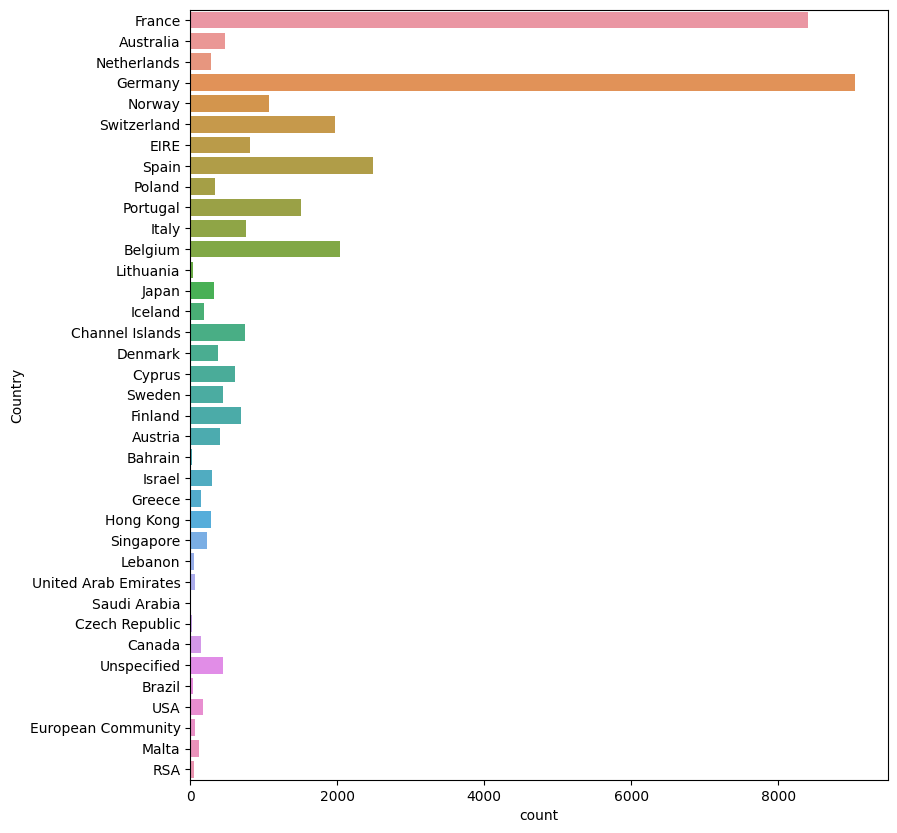

In [8]:
# Make figsize
plt.figure(figsize=(9,10))

# Bar plot by country
sns.countplot(y='Country', data=df)

There are many **sparse classes**. Countries like Lithuania, Brazil, and even the USA have a tiny number of transactions.

**Note:** This is at the transaction/line-item level. The number of customers for each country is even smaller because each customer has multiple transactions! Therefore, it's plain to see that clustering by country is not very efficient.

# 4. Transaction-level Cleaning
Before we aggregate to the customer level, we need to tidy up a few things at the transaction level.
* Technically, this is the **"line-item" level** because one invoice (a.k.a. transaction) spans multiple rows. However, we'll just refer to it as the "transaction level" for simplicity.
* Also the terms **"aggegrating up"** and **"rolling up"** are used interchangeability.

First, we need to check for any missing data before rolling up. If we don't, we might get confusing results later because rolling up to a higher level can sometimes hide the fact that data was missing at the lower level.

Display the number of missing observations for each feature.

In [9]:
# Missing data by feature
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     1418
Country           0
dtype: int64

'CustomerID' has missing observations
* Should we **label them as missing** (as for categorical features) or should we **flag and fill** them (as for numeric features)?
* We should do neither. Instead, we simply need to drop transactions with missing CustomerID.
* Think back to the project scope: We are trying to cluster customers in order to provide more tailored service!
* That means transactions with missing 'CustomerID' are actually pointless to keep.
* In other words, they should be considered "unwanted observations" instead of "missing data!".

Drop observations with missing customer ID's.

In [10]:
# Only keep transactions with CustomerID's
df = df[df.CustomerID.notnull()]

Next, just for clarity, convert the CustomerID's from floats into integers. (This is technically not required, but it's good practice to save ID's as either strings or integers so they don't get mixed up with other numeric features.)

In [11]:
# Convert customer ID's into integers
df['CustomerID'] = df.CustomerID.astype(int)

# Display first 5 CustomerID's in the transaction dataset
df.CustomerID.head()

0    12583
1    12583
2    12583
3    12583
4    12583
Name: CustomerID, dtype: int32

There's one feature we need to create at the transaction level.

Look back at the first 10 observations you displayed earlier.
* Are there any features that tell you how much money the customer spent on each transaction?
* Well, we have 'Quantity' and 'UnitPrice', but those are for individual units, not for the transaction.
* We need to multiply them together to get the Sales amount for that transaction.

In [12]:
# Create 'Sales' interaction feature
df['Sales'] = df.Quantity * df.UnitPrice

# Display first 5 Sales values in the transaction dataset
df.Sales.head()

0    90.0
1    90.0
2    45.0
3    10.2
4    15.6
Name: Sales, dtype: float64

Before moving on, save your cleaned transaction-level data as **cleaned_transactions.csv.**

In [13]:
# Save cleaned transaction-level data
df.to_csv('cleaned_transactions.csv', index=None)

# 5. Customer-level feature engineering
Now that we have a cleaned transaction-level dataset, it's time to **roll it up** (aggregate up) to the customer level, which we'll feed into our machine learning algorithms later.

We want 1 customer per row, and we want the features to represent information such as:
* Number of unique purchases by the customer
* Average cart value for the customer
* Total sales for the customer
* Etc.

To do so, we'll use two tools seen already:
* groupby() to roll up by customer.
* agg() to engineer aggregated features.

Aggegrate invoice data by customer. We'll engineer 1 feature:
* 'total_transactions' - the total number of unique transactions for each customer.

In [14]:
# Aggregate invoice data
invoice_data = df.groupby('CustomerID').InvoiceNo.nunique().reset_index()

# Rename the column
invoice_data.columns = ['CustomerID', 'total_transactions']

# Display invoice data for first 5 customers
invoice_data.head()


,CustomerID,total_transactions
0,12347,7
1,12348,4
2,12349,1
3,12350,1
4,12352,8


In [15]:
# Aggregate product data
product_data = df.groupby('CustomerID').agg(
    total_products=('StockCode', 'count'),
    total_unique_products=('StockCode', 'nunique')
).reset_index()

# Display product data for first 5 customers
product_data.head()


,CustomerID,total_products,total_unique_products
0,12347,182,103
1,12348,31,22
2,12349,73,73
3,12350,17,17
4,12352,85,59


By definition, 'total_unique_products' should always be less than or equal to 'total_products'.

Finally, aggregate sales data by customer. Engineer 2 features:
* 'total_sales' - the total sales for each customer.
* 'avg_product_value' - the average value of the products purchased by the customer (not the UnitPrice!).

In [16]:
# Roll up sales data
sales_data = df.groupby('CustomerID').agg(
    total_sales=('Sales', 'sum'),
    avg_product_value=('Sales', 'mean')
).reset_index()

# Display sales data for first 5 customers
sales_data.head()


,CustomerID,total_sales,avg_product_value
0,12347,4310.00,23.681319
1,12348,1797.24,57.975484
2,12349,1757.55,24.076027
3,12350,334.40,19.670588
4,12352,2506.04,29.482824


# 6. Intermediary levels
You won't always be able to easily roll up to customer-level directly. Sometimes, it will be easier to create intermediary levels first.

For example, let's say we wanted to calculate the average cart value for each customer.
* 'avg_product_value' isn't the same thing because it doesn't first group products that were purchased within the same "cart" (i.e. invoice).

Therefore, let's first aggregate cart data at the "cart-level."
* We'll group by 'CustomerID' AND by 'InvoiceID'. Remember, we're treating each invoice as a "cart."
* Then, we'll calculate 'cart_value' by taking the sum of the Sales column. This is the total sales by invoice (i.e. cart).
* Finally, we'll call .reset_index() to turn CustomerID and InvoiceID back into regular columns so we can perform another aggregation.

In [17]:
# Aggregate cart-level data (i.e. invoice-level)
cart_data = df.groupby(['CustomerID', 'InvoiceNo']).agg(
    cart_value=('Sales', 'sum')
).reset_index()

# Display cart data for first 20 carts
cart_data.head(20)


,CustomerID,InvoiceNo,cart_value
0,12347,537626,711.79
1,12347,542237,475.39
2,12347,549222,636.25
3,12347,556201,382.52
4,12347,562032,584.91
5,12347,573511,1294.32
6,12347,581180,224.82
7,12348,539318,892.80
8,12348,541998,227.44
9,12348,548955,367.00


In [18]:
# Reset index
cart_data.reset_index(inplace=True)

# Display cart data for first 10 CARTS
cart_data.head(10)

,index,CustomerID,InvoiceNo,cart_value
0,0,12347,537626,711.79
1,1,12347,542237,475.39
2,2,12347,549222,636.25
3,3,12347,556201,382.52
4,4,12347,562032,584.91
5,5,12347,573511,1294.32
6,6,12347,581180,224.82
7,7,12348,539318,892.80
8,8,12348,541998,227.44
9,9,12348,548955,367.00


Now that we have cart-level cart data, all we need to do is roll up by CustomerID again to get customer-level cart data.

Aggregate cart data by customer. Engineer 3 features:
* 'avg_cart_value' - average cart value by customer.
* 'min_cart_value' - minimum cart value by customer.
* 'max_cart_value' - maximum cart value by customer.

In [19]:
# Aggregate cart data (at customer-level)
agg_cart_data = cart_data.groupby('CustomerID').agg(
    avg_cart_value=('cart_value', 'mean'),
    min_cart_value=('cart_value', 'min'),
    max_cart_value=('cart_value', 'max')
).reset_index()

# Display cart data for first 5 CUSTOMERS
agg_cart_data.head()


,CustomerID,avg_cart_value,min_cart_value,max_cart_value
0,12347,615.714286,224.82,1294.32
1,12348,449.310000,227.44,892.80
2,12349,1757.550000,1757.55,1757.55
3,12350,334.400000,334.40,334.40
4,12352,313.255000,120.33,840.30


# 7. Joining various customer level dataframes
We have multiple dataframes that each contain customer-level features:
* invoice_data
* product_data
* sales_data
* agg_cart_data

Let's join the various customer-level datasets together with the .join() function.
* Just pick one of the customer-level dataframes and join it to a list of the others.
* By default, it will join the dataframes on their index... In this case, it will join by CustomerID, which is exactly what we want.
* You can read more about the .join() function in the official documentation.

In [20]:
# Merge customer-level data
customer_df = invoice_data.merge(product_data, on='CustomerID', how='left') \
                          .merge(sales_data, on='CustomerID', how='left') \
                          .merge(agg_cart_data, on='CustomerID', how='left')

# Display customer-level data for first 5 customers
customer_df.head()


,CustomerID,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
0,12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32
1,12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80
2,12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55
3,12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40
4,12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30


Finally, let's save customer_df as our **analytical base table** to use later.

**Very Important:** We will not set index=None because we want to keep the CustomerID's as the index (this will be important and we'll see later).

In [21]:
# Save analytical base table
customer_df.to_csv('analytical_base_table.csv')

# 8. Curse of Dimensionality.
Let's import the cleaned dataset (not the analytical base table) that we saved in previously.

In [22]:
# Read cleaned_transactions.csv
df = pd.read_csv('cleaned_transactions.csv')

In [23]:
# Get item_dummies - creates the vector of StockCode
item_dummies = pd.get_dummies(df.StockCode)

item_dummies.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85231B,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Now, add 'CustomerID' to this new dataframe so that we can roll up (aggregate) by customer later.

In [24]:
# Add CustomerID to item_dummies
item_dummies['CustomerID'] = df.CustomerID

# Display first 5 rows of item_dummies
item_dummies.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST,CustomerID
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583


Next, roll up the item dummies data into customer-level item data.

In [25]:
# Create item_data by aggregating at customer level
item_data = item_dummies.groupby('CustomerID').sum()

# Display first 5 rows of item_data
item_data.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85231B,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5


As you can see, even after rolling up to the customer level, most of the values are still 0. That means that most customers are not buying a huge array of different items, which is to be expected.

Finally, let's display the total number times each item was purchased.

In [26]:
# Total times each item was purchased
item_data.sum()

10002       12
10120        1
10125       13
10133        5
10135        4
          ... 
90202D       1
90204        1
C2           6
M           34
POST      1055
Length: 2574, dtype: int64

As you can see, most items were purchased less than a handful of times!

First of all, we've just created 2574 customer-level item features, which leads to The Curse of Dimensionality.
To make matters even worse, most of the values for many of those features are 0!

So, we'll introduce a couple of strategies for reducing the number of item features that we actually keep.

Before moving on, let's save this customer-level item dataframe as 'item_data.csv'. We'll use it again in the next module.

In [27]:
# Save item_data.csv
item_data.to_csv('item_data.csv')

## 8.3 Method 1 - Thresholding
One very simple and straightforward way to reduce the dimensionality of this item data is to set a threshold for keeping features.
* The rationale is that you might only want to keep **popular items.**
* For example, let's say item A was only purchased by 2 customers. Well, the feature for item A will be 0 for almost all observations, which isn't very helpful.
* On the other hand, let's say item B was purchased by 100 customers. The feature for item B will allow more meaningful comparisons.

To make this concrete, assume we only wish to keep item features for the 20 most popular items.

First, we can see which items those are and the number of times they were purchased.
* Take the sum by column.
* Sort the values.
* Look at the last 20 (since they are sorted in ascending order by default)

In [28]:
# Display most popular 20 items
item_data.sum().sort_values().tail(120)

22748        50
22847        50
15056BL      50
23159        50
85014B       50
           ... 
22556       179
22554       197
22423       222
22326       271
POST       1055
Length: 120, dtype: int64

Next, if we take the .index of the above series, we can get just a list of the StockCodes for those 20 items.

In [29]:
# Get list of StockCodes for the 20 most popular items
top_20_items = item_data.sum().sort_values().tail(120).index

top_20_items

Index(['22748', '22847', '15056BL', '23159', '85014B', '23243', '23231',
       '22898', '23388', '23255',
       ...
       '21212', '22551', '22629', '22328', '21731', '22556', '22554', '22423',
       '22326', 'POST'],
      dtype='object', length=120)

Finally, we can keep only the features for those 20 items.

In [30]:
# Keep only features for top 20 items
top_20_item_data = item_data[top_20_items]

# Shape of remaining dataframe
top_20_item_data.shape

(414, 120)

In [31]:
top_20_item_data.head()

,22748,22847,15056BL,23159,85014B,23243,23231,22898,23388,23255,22966,22558,21558,22356,84997C,23292,22699,22331,22385,23480,84375,21156,21242,22417,21122,84997B,22895,22962,22557,22907,23307,20676,21977,21976,23293,22661,23290,22627,84879,20682,22367,23236,22355,22197,22553,20685,23108,22384,21936,20728,...,22631,22090,23199,21915,23203,84997D,22029,23209,23254,22077,22960,23256,22492,22467,22726,22382,23240,23245,21094,21086,23206,22352,22727,22138,22720,21559,22728,22555,20724,20712,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,2,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,5,0,0,0,3,0,0,0,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0
12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
12350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
12352,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5


These 20 features are much more manageable than the 2574 from earlier, and they are arguably the most important features because they are the most popular items.

Finally, save this top 20 items dataframe as 'threshold_item_data.csv'.

In [32]:
# Save threshold_item_data.csv
top_20_item_data.to_csv('threshold_item_data.csv')

## 8.4 PCA
Let's import the full item data that we saved in the previous module (before applying thresholds)

This time, we'll also pass in the argument index_col=0 to tell Pandas to treat the first column (CustomerID) as the index.

In [33]:
# Read item_data.csv
item_data = pd.read_csv('item_data.csv', index_col=0)

In [34]:
# Display item_data's shape
item_data.shape

(414, 2574)

**Principal Component Analysis (PCA)** is an Unsupervised Learning task that creates a sequence of new, uncorrelated features that each try to maximize its "explained variance" of the original dataset.
* It does so by generating linear combinations from your original features.
* These new features are meant to replace the original ones.

Here's where dimensionality reduction comes into play, and it's brilliantly simple:
* You don't need to keep all of the principal components!
* You can just keep some number of the "best" components, a.k.a. the ones that explain the most variance.
* Remember, PCA creates a sequence of principal components and each one tries to capture the most variance after accounting for the ones before it.

First, **scale item_data**, which you imported.

In [35]:
# Initialize instance of StandardScaler
scaler = StandardScaler()

# Fit and transform item_data
item_data_scaled = scaler.fit_transform(item_data)

# Display first 5 rows of item_data_scaled
item_data_scaled[:5]

array([[-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.68068072],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183,  0.38776219],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
         5.53128397,  0.65487292]])

Next, initialize and fit an instance of the PCA transformation.

Keep all of the components for now (just don't pass in any argument).

In [36]:
# Initialize and fit a PCA transformation
pca = PCA()
pca.fit(item_data_scaled)

PCA()

Finally, generate new "principal component features" from item_data_scaled.

In [37]:
# Generate new features
PC_items = pca.transform(item_data_scaled)

# Display first 5 rows
PC_items[:5]

array([[ 5.87614052e+00,  4.82891689e+00, -4.95545069e-01, ...,
        -6.62646278e-04, -4.43629806e-05,  3.04270498e-15],
       [-4.21983747e+00,  1.22621722e+00, -1.88191211e+00, ...,
        -2.11471782e-04, -2.69154340e-04,  6.24500451e-16],
       [-1.26084676e+00,  2.38766371e+00, -7.31483440e-02, ...,
         2.57750179e-04, -2.05682324e-04,  2.09207651e-15],
       [-4.92931983e+00, -7.14858724e-01, -1.58093026e+00, ...,
        -1.98603886e-03,  9.92316312e-05,  1.48318857e-15],
       [-2.05311348e+00,  2.11095022e+00,  1.84807021e-01, ...,
        -3.43415269e-04, -1.32981672e-04,  4.16333634e-16]])

### Explained Variance
It's very helpful to calculate and plot the cumulative explained variance.
* This will tell us the total amount of variance we'd capture if we kept up to the n-th component.
* First, we'll use np.cumsum() to calculate the cumulative explained variance.
* Then, we'll plot it so we can see how many PC features we'd need to keep in order to capture most of the original variance.

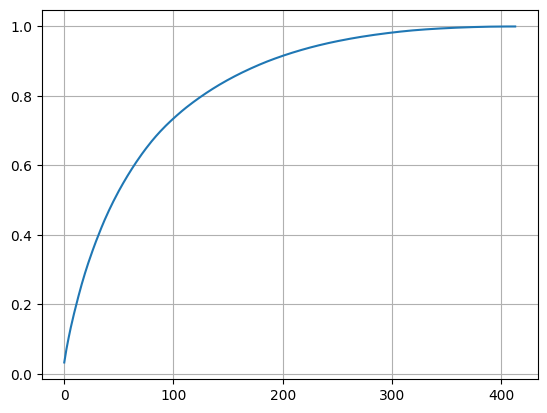

In [38]:
# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.grid()
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)

This chart is saying: To capture about 98% of the variance, we'd need to keep around 300 components.

We can confirm:

In [39]:
# How much variance we'd capture with the first 125 components
cumulative_explained_variance[300]

0.9824241831916605

Reducing 2574 features down to 300 (about 88% fewer features) while capturing almost 80% of the original variance is certainly not bad!

Initialize and fit another PCA transformation.
* This time, only keep 300 components.
* Generate the principal component features from the fitted instance and name the new matrix PC_items.
* Then, display the shape of PC_items to confirm it only has 300 features.

In [40]:
pca = PCA(n_components=300)

# Fit and transform item_data_scaled
PC_items = pca.fit_transform(item_data_scaled)

# Display shape of PC_items
PC_items.shape

(414, 300)

Next, for convenience, let's put PC_items into a new dataframe.

We'll also name the columns and update its index to be the same as the orginal item_data's index.

In [41]:
# Put PC_items into a dataframe
items_pca = pd.DataFrame(PC_items)

# Name the columns
items_pca.columns = ['PC{}'.format(i + 1) for i in range(PC_items.shape[1])]

# Update its index
items_pca.index = item_data.index

# Display first 5 rows
items_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,...,PC251,PC252,PC253,PC254,PC255,PC256,PC257,PC258,PC259,PC260,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270,PC271,PC272,PC273,PC274,PC275,PC276,PC277,PC278,PC279,PC280,PC281,PC282,PC283,PC284,PC285,PC286,PC287,PC288,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,5.876141,4.828917,-0.495545,3.093849,-0.633706,-11.534092,2.161996,7.116957,5.336009,4.424414,4.637002,2.316503,12.310783,1.986696,-11.431269,5.617791,-2.177268,7.665832,-12.135817,-16.049000,-5.949238,7.814288,40.518194,-35.575039,-17.557418,6.869259,20.886868,2.296657,-26.160394,-32.580135,7.880285,12.358371,6.826718,-32.957865,-4.405057,-17.238628,-11.272274,-14.487767,-2.766330,4.736717,-6.985885,-1.464059,10.603071,1.239909,3.086324,5.336237,-0.410776,1.616712,-6.383660,3.065176,...,0.005546,-0.408694,-0.236970,0.002559,0.159540,-0.232456,-0.197290,-0.163825,-0.177060,0.178219,0.168555,-0.095312,-0.135938,-0.193615,-0.120885,0.145953,0.078112,-0.105638,0.175680,-0.260642,-0.151423,-0.097712,0.070739,-0.058936,0.009539,0.018393,-0.112746,-0.018552,0.028850,-0.096283,0.099854,-0.151039,0.147734,-0.018021,0.003581,-0.075082,-0.137251,-0.014977,0.082624,-0.050226,-0.033765,0.009928,-0.029918,0.026455,0.148441,0.070982,0.036946,0.004781,0.023515,-0.116742
12348,-4.219837,1.226217,-1.881912,-0.174340,0.817996,1.160834,-0.871683,-0.846634,0.460240,0.854274,-0.401793,0.981803,-1.104237,0.770191,-0.092975,-0.313393,-0.448633,1.207301,0.381678,-0.469152,0.185789,0.054586,0.499987,0.373514,1.226616,-0.773072,-0.270124,0.850016,-0.370482,-0.573939,1.012802,-0.580827,0.949802,-0.733970,0.353890,-0.387479,-0.298541,0.396418,0.154925,0.333479,-0.466264,0.703453,1.200580,-0.202163,-0.871795,-0.055069,-0.421732,-1.623011,-0.397691,0.452590,...,-0.229812,1.061278,-0.247236,-1.174951,0.582235,1.001817,-0.461936,-0.494862,0.757913,0.671236,1.307674,-1.197105,0.842016,-0.765469,0.181301,1.289559,0.268968,0.393461,-0.228224,0.202218,0.666253,0.062306,-0.844770,-0.353227,-1.065176,-1.212613,0.202016,0.448648,-0.214620,0.304091,-0.736644,0.010329,-0.138479,-0.001577,0.186846,-0.344384,0.123619,0.618076,-0.868189,0.157717,0.164640,0.339974,-0.462560,-1.157319,0.057072,0.457935,-0.169531,0.089649,0.185382,-0.112940
12349,-1.260847,2.387664,-0.073148,-1.119161,-0.034339,-3.715390,-0.343602,-0.149045,-0.790001,-0.379234,1.570090,0.183310,0.223639,-0.051066,3.179090,-0.512679,-1.839577,0.383216,0.317492,-0.003006,-0.420161,0.456436,-0.789675,1.751367,-1.481236,0.757191,-0.912292,0.771947,0.503370,-1.345637,0.286381,0.668565,0.085125,-0.216750,-0.667408,-1.535679,0.783800,-1.418823,-0.098816,-0.929870,0.090829,-0.095243,-0.163215,0.700639,1.381550,-0.243735,-0.105134,-0.176475,0.862919,1.685210,...,0.592411,0.302645,-0.239348,-0.412600,0.925713,-0.356092,0.697102,0.121195,1.081222,0.533342,0.024960,-0.247410,0.416891,0.263011,-0.034701,-0.508745,0.031081,0.738275,0.575990,0.024049,0.205361,-0.249023,-0.032183,0.047170,-0.010789,-0.048130,0.153077,0.058120,0.483951,-0.360841,-0.278765,0.184137,0.456213,-0.327130,-0.421571,-0.054582,-0.119020,-0.744506,0.488342,0.429883,0.309958,0.124931,0.042972,0.050096,0.647841,0.179191,0.396051,-0.389892,-0.317983,0.505389
12350,-4.929320,-0.714859,-1.580930,-0.469767,-0.116290,0.647835,0.112904,-1.336313,1.547069,-1.190409,-0.213170,1.057289,-0.475002,0.856574,-1.305371,0.242700,0.268312,1.952558,-0.227722,0.569825,-0.186512,0.903530,1.364748,0.178124,-0.260398,-0.168826,-0.681952,1.081305,-0.155239,-0.397163,0.240050,0.634068,-1.447081,-0.186097,-0.315379,-0.306430,-1.359020,-0.001474,0.579057,-0.248312,0.588130,-0.217987,0.284600,0.525267,-0.531670,-0.101394,-1.

* Now we have a dataframe of 300 customer-level principal component features.
* These were generated from the 300 principal components that explained the most variance for the original features.
* The index of this PCA item dataframe contains CustomerID's, which will make it possible for us to join this to our analytical base table.

Finally, save this item dataframe with PCA features as 'pca_item_data.csv'.
* Next, we'll compare the clusters made from using these features against those in 'threshold_item_data.csv'.
* Do not set index=None because we want to keep the CustomerID's as the index.

In [42]:
# Save pca_item_data.csv
items_pca.to_csv('pca_item_data.csv')

# 9. KMeans Clustering
Let's import 3 CSV files we've saved throughout this project.
* Let's import 'analytical_base_table.csv' as base_df.
* Let's import 'threshold_item_data.csv' as threshold_item_data.
* Let's import 'pca_item_data.csv' as pca_item_data.
* Set index_col=0 for each one to use CustomerID as the index.

In [43]:
# Import analytical base table
base_df = pd.read_csv('analytical_base_table.csv', index_col=0)

# Import thresholded item features
threshold_item_data = pd.read_csv('threshold_item_data.csv', index_col=0)

# Import PCA item features
pca_item_data = pd.read_csv('pca_item_data.csv', index_col=0)

Print the shape of each one to make sure we're on the same page.

In [44]:
# Print shape of each dataframe
print( base_df.shape )
print( threshold_item_data.shape )
print( pca_item_data.shape )

(414, 9)
(414, 120)
(414, 300)


Because K-Means creates clusters based on distances, and because distances are calculated by between observations defined by their feature values, **the features you choose to input into the algorithm heavily influence the clusters that are created.**

For this project, we will look at 3 possible feature sets and compare the clusters created from them. We'll try:
1. Only purchase pattern features ("Base DF")
2. Purchase pattern features + item features chosen by thresholding ("Threshold DF")
3. Purchase pattern features + principal component features from items ("PCA DF")

Create a threshold_df by joining base_df with threshold_item_data.

In [45]:
# Join base_df with threshold_item_data
threshold_df = base_df.join(threshold_item_data)

# Display first 5 rows of threshold_df
threshold_df.head()

,CustomerID,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,22748,22847,15056BL,23159,85014B,23243,23231,22898,23388,23255,22966,22558,21558,22356,84997C,23292,22699,22331,22385,23480,84375,21156,21242,22417,21122,84997B,22895,22962,22557,22907,23307,20676,21977,21976,23293,22661,23290,22627,84879,20682,22367,...,22631,22090,23199,21915,23203,84997D,22029,23209,23254,22077,22960,23256,22492,22467,22726,22382,23240,23245,21094,21086,23206,22352,22727,22138,22720,21559,22728,22555,20724,20712,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
0,12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create a pca_df by joining base_df with pca_item_data.

In [46]:
# Join base_df with pca_item_data
pca_df = base_df.join(pca_item_data)

# Display first 5 rows of pca_df
pca_df.head()

,CustomerID,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,...,PC251,PC252,PC253,PC254,PC255,PC256,PC257,PC258,PC259,PC260,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270,PC271,PC272,PC273,PC274,PC275,PC276,PC277,PC278,PC279,PC280,PC281,PC282,PC283,PC284,PC285,PC286,PC287,PC288,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300
0,12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Number of clusters
So, how many clusters should you set?
* As with much of Unsupervised Learning, there's no right or wrong answer.
* Typically, you should consider how your client/key stakeholder will use the clusters.
* For example, let's say our client, the online gift retailer, employs 3 customer service reps, and they want to assign one cluster to each rep.
* In that case, the obvious answer is 3.
* For this project, we'll set the number of clusters to 3. However, you should always feel free to adapt this number depending on what you need.

First scale both the dataframes

In [47]:
# Initialize instance of StandardScaler
t_scaler = StandardScaler()
p_scaler = StandardScaler()

# Fit and transform
threshold_df_scaled = t_scaler.fit_transform(threshold_df)
pca_df_scaled = p_scaler.fit_transform(pca_df)

K-Means with threshold_df

In [57]:
t_kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 123)

In [58]:
#remove null values
threshold_df_scaled = np.nan_to_num(threshold_df_scaled)


In [59]:
t_kmeans.fit(threshold_df_scaled)
threshold_df['cluster'] = t_kmeans.fit_predict(threshold_df_scaled)

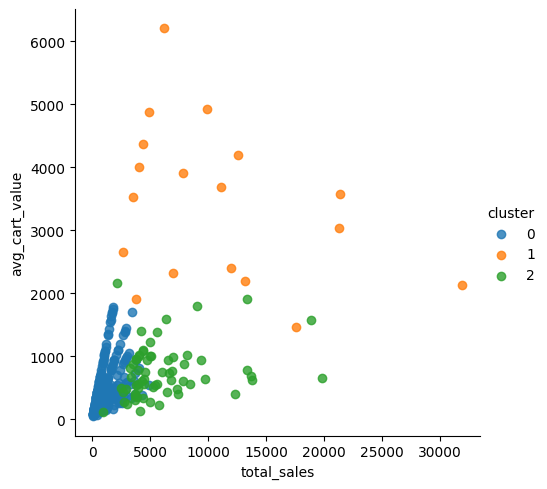

In [60]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=threshold_df, fit_reg=False)

K-Means with pca_df

In [61]:
p_kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 123)

In [62]:
#remove null values
pca_df_scaled = np.nan_to_num(pca_df_scaled)

In [63]:
p_kmeans.fit(pca_df_scaled)
pca_df['cluster'] = p_kmeans.fit_predict(pca_df_scaled)

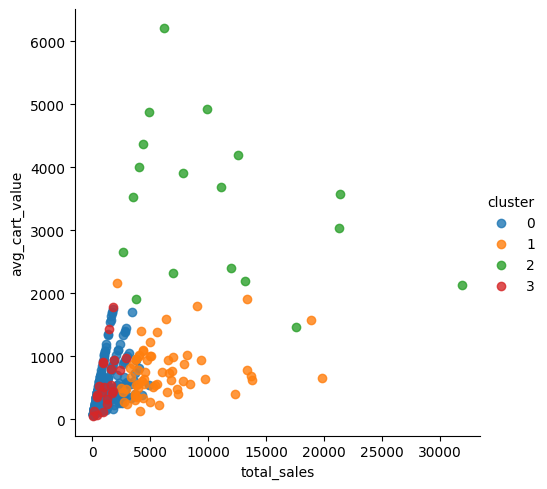

In [64]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=pca_df, fit_reg=False)

In [56]:
# Similary between base_df.cluster and threshold_df.cluster
adjusted_rand_score(pca_df.cluster, threshold_df.cluster)

0.8361685481960756